In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted

Matplotlib is building the font cache; this may take a moment.


In [2]:
# (선택적) SMOTE 사용 가능 여부 체크
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_OK = True
except Exception:
    IMBLEARN_OK = False

In [3]:
# 1) 불균형 데이터 만들기 (양성:음성 ≈ 1:14)
X, y = make_classification(
    n_samples=6000, n_features=20, n_informative=6, n_redundant=2,
    n_clusters_per_class=2, weights=[0.93, 0.07], flip_y=0.01, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

In [4]:
# 유틸: 모델 학습 + 평가
def fit_eval(name, estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    # predict_proba 없으면 decision_function 사용
    if hasattr(estimator, "predict_proba"):
        y_score = estimator.predict_proba(X_test)[:, 1]
    else:
        y_score = estimator.decision_function(X_test)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1  = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_score)
    cm  = confusion_matrix(y_test, y_pred)

    print(f"\n=== [{name}] 성능 ===")
    print(f"Accuracy: {acc:.3f} | Precision: {pre:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    fpr, tpr, _ = roc_curve(y_test, y_score)
    return fpr, tpr, auc

In [5]:
# 2) 세 가지 접근 정의
# (A) 기본: 표준화 + 로지스틱
base = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, n_jobs=None, random_state=42))
])

# (B) class_weight='balanced' 적용
balanced = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=None, random_state=42))
])

# (C) 선택: SMOTE 오버샘플링 + 로지스틱 (imblearn 설치 시)
if IMBLEARN_OK:
    from imblearn.pipeline import Pipeline as ImbPipeline
    smote_model = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("scaler", StandardScaler(with_mean=False) if np.issubdtype(X_train.dtype, np.integer) else StandardScaler()),
        ("clf", LogisticRegression(max_iter=200, n_jobs=None, random_state=42))
    ])


=== [기본] 성능 ===
Accuracy: 0.944 | Precision: 0.719 | Recall: 0.376 | F1: 0.494 | ROC-AUC: 0.894
Confusion Matrix:
 [[1375   16]
 [  68   41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1391
           1       0.72      0.38      0.49       109

    accuracy                           0.94      1500
   macro avg       0.84      0.68      0.73      1500
weighted avg       0.94      0.94      0.94      1500


=== [가중치 균형] 성능 ===
Accuracy: 0.823 | Precision: 0.269 | Recall: 0.835 | F1: 0.407 | ROC-AUC: 0.901
Confusion Matrix:
 [[1144  247]
 [  18   91]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.90      1391
           1       0.27      0.83      0.41       109

    accuracy                           0.82      1500
   macro avg       0.63      0.83      0.65      1500
weighted avg       0.93      0.82      0.86      1500


=== [

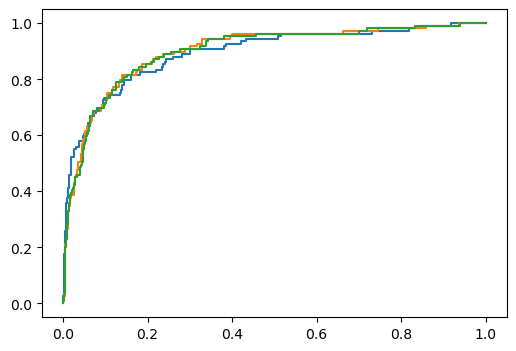

In [ ]:
# 3) 학습 + 평가 + ROC 곡선 비교
plt.figure(figsize=(6, 4))  # 단일 차트 (한 플롯만 사용)
labels = []
fprs_tprs_aucs = []

fpr_a, tpr_a, auc_a = fit_eval("기본", base, X_train, y_train, X_test, y_test)
plt.plot(fpr_a, tpr_a, label=f"기본 (AUC={auc_a:.3f})")
labels.append(f"기본 (AUC={auc_a:.3f})")
fprs_tprs_aucs.append((fpr_a, tpr_a, auc_a))

fpr_b, tpr_b, auc_b = fit_eval("가중치 균형", balanced, X_train, y_train, X_test, y_test)
plt.plot(fpr_b, tpr_b, label=f"가중치 균형 (AUC={auc_b:.3f})")
labels.append(f"가중치 균형 (AUC={auc_b:.3f})")
fprs_tprs_aucs.append((fpr_b, tpr_b, auc_b))

if IMBLEARN_OK:
    fpr_c, tpr_c, auc_c = fit_eval("SMOTE", smote_model, X_train, y_train, X_test, y_test)
    plt.plot(fpr_c, tpr_c, label=f"SMOTE (AUC={auc_c:.3f})")
    labels.append(f"SMOTE (AUC={auc_c:.3f})")
    fprs_tprs_aucs.append((fpr_c, tpr_c, auc_c))
else:
    print("\n[알림] imbalanced-learn이 설치되어 있지 않아 SMOTE 비교를 생략합니다.")
    print("설치하려면: pip install imbalanced-learn")

/var/folders/q6/0h2tpfvn58zdcfpr738g48ww0000gn/T/ipykernel_1587/2442806202.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


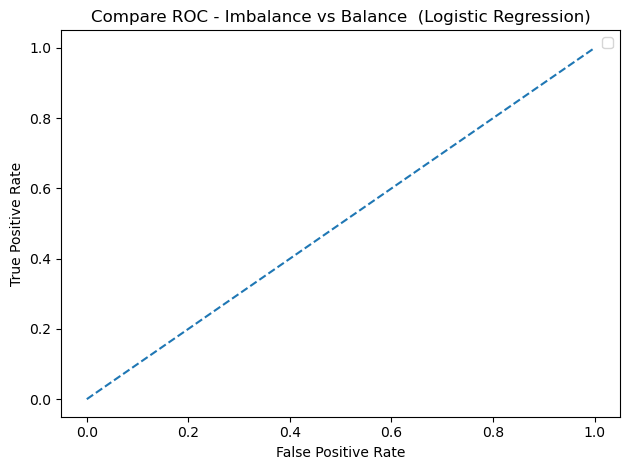

In [9]:
# ROC 시각화
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Compare ROC - Imbalance vs Balance  (Logistic Regression)")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# 4) 해석 가이드 (간단 인쇄)
print("\n[해석 가이드]")
print("- 불균형 데이터에서는 '정확도'만 보면 과대평가되기 쉽습니다(대다수 클래스만 맞춰도 높게 나옴).")
print("- '재현율(Recall)'과 'ROC-AUC'를 함께 보세요. 소수(양성) 클래스 탐지 능력을 반영합니다.")
print("- class_weight='balanced' 또는 SMOTE 같은 리샘플링을 쓰면 보통 재현율이 개선됩니다.")


[해석 가이드]
- 불균형 데이터에서는 '정확도'만 보면 과대평가되기 쉽습니다(대다수 클래스만 맞춰도 높게 나옴).
- '재현율(Recall)'과 'ROC-AUC'를 함께 보세요. 소수(양성) 클래스 탐지 능력을 반영합니다.
- class_weight='balanced' 또는 SMOTE 같은 리샘플링을 쓰면 보통 재현율이 개선됩니다.
